In [1]:
#%%capture
!pip install fft-conv-pytorch imagecorruptions psfmodels

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!mkdir data data/blur data/gt

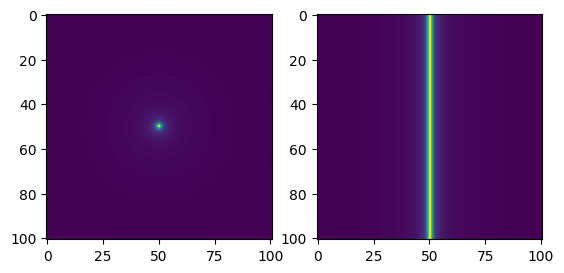

In [1]:
import torch
import torch.nn.functional as F
import numpy as np

import psfmodels as psfm
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

# generate centered psf with a point source at `pz` microns from coverslip
nx, ny, nz = 101, 101, 101
psf = psfm.make_psf(nx, ny, dxy=0.2, dz=0., pz=0.) # dxy=0.2, dz=0.5, pz=0.
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(psf[nz//2], norm=PowerNorm(gamma=0.4))
ax2.imshow(psf[:, nx//2], norm=PowerNorm(gamma=0.4))
plt.show()

k_ = psf/np.sum(psf)
k_l = psf.shape[0]

k_torch = torch.from_numpy(k_.copy()).double()
k_torch = k_torch.unsqueeze(0).unsqueeze(0)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile

def create_sphere(arr_size, center, r):
    coords = np.ogrid[:arr_size[0], :arr_size[1], :arr_size[2]]
    distance = np.sqrt((coords[0] - center[0])**2 + (coords[1]-center[1])**2 + (coords[2]-center[2])**2) 
    return 1*(distance <= r)

def create_hollow_sphere(arr_size, center, r):
    assert r >= 3

    t = np.random.randint(0, r//2 + 1)

    a = create_sphere(arr_size, center, r)
    b = create_sphere(arr_size, center, r - t)
    return a - b

# ---------------------------------------------------------------

def place_sphere(canvas, small=False):
    c_dim_z = canvas.shape[0]
    c_dim_xy = canvas.shape[1]

    if small:
        r = np.random.randint(3,5)
    else:
        r = np.clip(np.random.randint(10,50), 0, c_dim_z//2-1)

    x_c = np.random.randint(r,c_dim_xy-r)
    y_c = np.random.randint(r,c_dim_xy-r)
    z_c = np.random.randint(r,c_dim_z-r)

    sphere_center = (z_c,y_c,x_c)

    h = np.random.randint(0,2)
    if h == 0:
        obj = create_sphere(canvas.shape, sphere_center, r)
    else:
        obj = create_hollow_sphere(canvas.shape, sphere_center, r)

    canvas[np.where(obj)] = np.clip(np.random.normal(loc=0.8, scale=0.1, size=None), 0, 1)
    return canvas


# long block along z-axis
def place_z_block(canvas, small=False):
    c_dim_z = canvas.shape[0]
    c_dim_xy = canvas.shape[1]

    if small:
        x_len = np.random.randint(1,5)
        y_len = np.random.randint(1,5)
        z_len = np.random.randint(1,np.min([10, c_dim_z]))
    else:
        x_len = np.random.randint(1,30)
        y_len = np.random.randint(1,30)
        z_len = np.clip(np.random.randint(1,100), 0, c_dim_z-1)

    x_start = np.random.randint(0,c_dim_xy-x_len)
    y_start = np.random.randint(0,c_dim_xy-y_len)
    z_start = np.random.randint(0,c_dim_z-z_len)

    obj = np.zeros((c_dim_z, c_dim_xy, c_dim_xy))

    obj[z_start:z_start+z_len, y_start:y_start+y_len, x_start:x_start+x_len] = np.ones((z_len, y_len, x_len))

    canvas[np.where(obj)] = 1#np.clip(np.random.normal(loc=0.8, scale=0.1, size=None), 0, 1)
    return canvas

# long block along y-axis
def place_y_block(canvas, small=False):
    c_dim_z = canvas.shape[0]
    c_dim_xy = canvas.shape[1]

    if small:
        x_len = np.random.randint(1,5)
        y_len = np.random.randint(1,10)
        z_len = np.random.randint(1,5)
    else:
        x_len = np.random.randint(1,30)
        y_len = np.random.randint(1,100)
        z_len = np.random.randint(1,30)

    x_start = np.random.randint(0,c_dim_xy-x_len)
    y_start = np.random.randint(0,c_dim_xy-y_len)
    z_start = np.random.randint(0,c_dim_z-z_len)

    obj = np.zeros((c_dim_z, c_dim_xy, c_dim_xy))

    obj[z_start:z_start+z_len, y_start:y_start+y_len, x_start:x_start+x_len] = np.ones((z_len, y_len, x_len))

    canvas[np.where(obj)] = 1#np.clip(np.random.normal(loc=0.8, scale=0.1, size=None), 0, 1)
    return canvas

# long block along x-axis
def place_x_block(canvas, small=False):
    c_dim_z = canvas.shape[0]
    c_dim_xy = canvas.shape[1]

    if small:
        x_len = np.random.randint(1,10)
        y_len = np.random.randint(1,5)
        z_len = np.random.randint(1,5)
    else:
        x_len = np.random.randint(1,100)
        y_len = np.random.randint(1,30)
        z_len = np.random.randint(1,30)

    x_start = np.random.randint(0,c_dim_xy-x_len)
    y_start = np.random.randint(0,c_dim_xy-y_len)
    z_start = np.random.randint(0,c_dim_z-z_len)

    obj = np.zeros((c_dim_z, c_dim_xy, c_dim_xy))

    obj[z_start:z_start+z_len, y_start:y_start+y_len, x_start:x_start+x_len] = np.ones((z_len, y_len, x_len))

    canvas[np.where(obj)] = 1#np.clip(np.random.normal(loc=0.8, scale=0.1, size=None), 0, 1)
    return canvas

# ---------------------------------------------------------------
c_dim_xy = 512
c_dim_z = 11 # 32
# ---------------------------------------------------------------
canvas = np.zeros((c_dim_z,c_dim_xy,c_dim_xy)) + 0.1

# for _ in range(300): # 300
#     canvas = place_sphere(canvas)

# for _ in range(40): # 40
#     canvas = place_x_block(canvas)
#     canvas = place_y_block(canvas)
#     canvas = place_z_block(canvas)

for _ in range(100): # 200
    canvas = place_sphere(canvas, small=True)
    canvas = place_x_block(canvas, small=True)
    canvas = place_y_block(canvas, small=True)
    canvas = place_z_block(canvas, small=True)

In [33]:
from fft_conv_pytorch import fft_conv
import imgaug.augmenters as iaa

x_torch = torch.from_numpy(canvas).double()
x_torch = F.pad(
    x_torch, 
    (k_l//2,k_l//2,k_l//2,k_l//2,k_l//2,k_l//2), 
    mode='constant', 
    value=torch.mean(x_torch)
)

x_torch_1 = x_torch.unsqueeze(0).unsqueeze(0)

y_torch_1 = fft_conv(x_torch_1, k_torch)

np_blur = y_torch_1.detach().cpu().numpy()

yy = 1 - np.mean(np_blur[0,0],0)

rates = torch.rand((yy.shape))
print(rates)

y_torch_2 = yy + torch.poisson(rates).numpy() * 0.005

np_blur = (y_torch_2 + torch.randn(y_torch_2.shape).detach().cpu().numpy()*0.005)

np_blur = (np_blur*255.).astype(np.uint8)
jpeg = iaa.JpegCompression(compression=10)
np_blur = jpeg(images=np_blur)

In [34]:
import imgaug.augmenters as iaa

np_blur = y_torch_1.detach().cpu().numpy()

yy = 1 - np.mean(np_blur[0,0],0)

rates = torch.rand((yy.shape))
print(rates)

y_torch_2 = yy + torch.poisson(rates).numpy() * 0.005

np_blur = (y_torch_2 + torch.randn(y_torch_2.shape).detach().cpu().numpy()*0.005)

np_blur = (np_blur*255.).astype(np.uint8)
jpeg = iaa.JpegCompression(compression=10)
np_blur = jpeg(images=np_blur)

tensor([[0.8651, 0.4368, 0.3656,  ..., 0.1883, 0.5749, 0.4905],
        [0.3486, 0.2971, 0.3361,  ..., 0.7821, 0.7708, 0.0129],
        [0.2790, 0.2675, 0.2626,  ..., 0.9035, 0.4415, 0.7968],
        ...,
        [0.3190, 0.0576, 0.9046,  ..., 0.9466, 0.5671, 0.8626],
        [0.2898, 0.0487, 0.3054,  ..., 0.9033, 0.8114, 0.8149],
        [0.6875, 0.7584, 0.4332,  ..., 0.7998, 0.3123, 0.0607]])


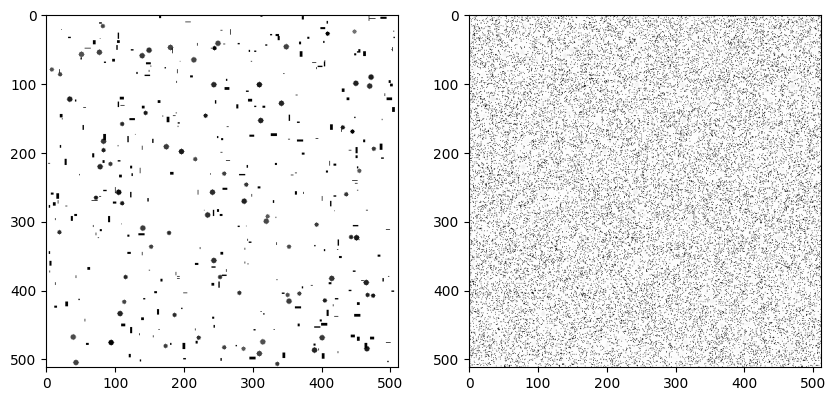

In [28]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(1 - np.max(canvas,0), cmap='gray', vmin=0, vmax=1)
plt.subplot(1,2,2)
plt.imshow(np_blur, cmap='gray', vmin=0, vmax=255)
plt.show()

In [9]:
from PIL import Image

INDEX=14

Image.fromarray(np_blur).convert('L').save('data/blur/'+str(INDEX)+'.png')

tmp = (1 - np.mean(canvas,0))
# tmp = (tmp - np.min(tmp))/(np.max(tmp) - np.min(tmp))
Image.fromarray(tmp*255.).convert('L').save('data/gt/'+str(INDEX)+'.png')

In [ ]:
!tar czf data.tar.gz data